<a href="https://colab.research.google.com/github/Poorya0071/Time_Series-/blob/main/time_series_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Univariate Time Series Forecasting 



The aim of this study is to use TensorFlow to perform time series forecasting on temperature data. The TensorFlow library is a powerful tool that allows for the implementation and training of deep learning models. Time series forecasting involves predicting future values of a time-dependent variable based on past observations. In this case, the variable of interest is temperature. By analyzing temperature data and using TensorFlow to build a forecasting model, we can potentially make more accurate predictions about future temperature values.

In [142]:
# import some required libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [116]:
# a useful function to plot the time series data.
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):

  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Temprature")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

In this section, we introduce two functions that are designed to evaluate the performance of the forecasting model. These functions calculate relevant metrics such as mean absolute error and mean squared error, which allow us to quantify the accuracy of the model's predictions. By analyzing these metrics, we can gain insight into the quality of the model and identify areas for improvement.

In [34]:
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [35]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [37]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7

In [38]:
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [39]:

# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [40]:
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [44]:
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [149]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True)

In [48]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

Now that we have defined the necessary functions for evaluating the model, we will proceed to load the temperature dataset. This dataset will serve as the basis for training and testing the model, and will be used to generate forecasts of temperature values. The data will be imported and processed as needed, before being passed to the model for training and evaluation.

In [74]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2023-01-05 14:50:00--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.001s  

2023-01-05 14:50:00 (43.9 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



In [81]:
import pandas as pd
data = pd.read_csv('/tmp/daily-min-temperatures.csv', parse_dates=["Date"], 
                 index_col=["Date"])

In [82]:
data.describe()

,Temp
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


In [83]:
data.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


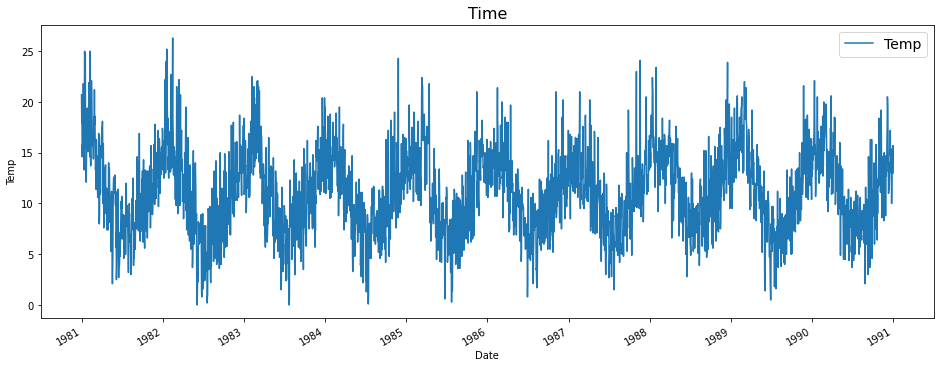

In [87]:
data.Temp.plot(figsize=(16, 6))
plt.ylabel("Temp")
plt.title("Time", fontsize=16)
plt.legend(fontsize=14);

In [102]:
data.index

DatetimeIndex(['1981-01-01', '1981-01-02', '1981-01-03', '1981-01-04',
               '1981-01-05', '1981-01-06', '1981-01-07', '1981-01-08',
               '1981-01-09', '1981-01-10',
               ...
               '1990-12-22', '1990-12-23', '1990-12-24', '1990-12-25',
               '1990-12-26', '1990-12-27', '1990-12-28', '1990-12-29',
               '1990-12-30', '1990-12-31'],
              dtype='datetime64[ns]', name='Date', length=3650, freq=None)

In [112]:
timesteps = data.index.to_numpy()
Temp = data["Temp"].to_numpy()

timesteps[:10], Temp[:10]

(array(['1981-01-01T00:00:00.000000000', '1981-01-02T00:00:00.000000000',
        '1981-01-03T00:00:00.000000000', '1981-01-04T00:00:00.000000000',
        '1981-01-05T00:00:00.000000000', '1981-01-06T00:00:00.000000000',
        '1981-01-07T00:00:00.000000000', '1981-01-08T00:00:00.000000000',
        '1981-01-09T00:00:00.000000000', '1981-01-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([20.7, 17.9, 18.8, 14.6, 15.8, 15.8, 15.8, 17.4, 21.8, 20. ]))

In [113]:

# Create train and test splits the right way for time series data
split_size = int(0.8 * len(Temp)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], Temp[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], Temp[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2920, 730, 2920, 730)

#### Let's Visualize data.

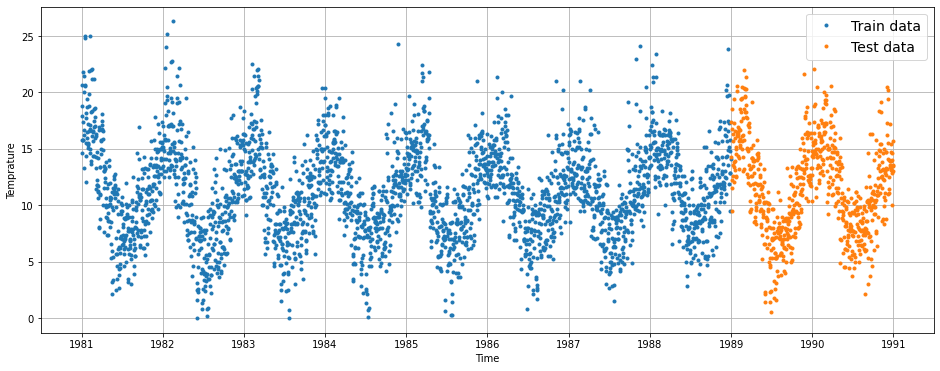

In [117]:
plt.figure(figsize=(16, 6))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

Before implementing a deep learning model for time series forecasting, it is instructive to compare its performance to a simpler, "naive" model. A naive model for time series forecasting simply predicts that the next time step will have the same value as the current time step. This provides a baseline against which more complex models can be compared. By comparing the performance of the deep learning model to the naive model, we can determine whether the added complexity of the deep learning model is justified by improved forecasting accuracy.

In [118]:
naive_forecast = y_test[:-1]

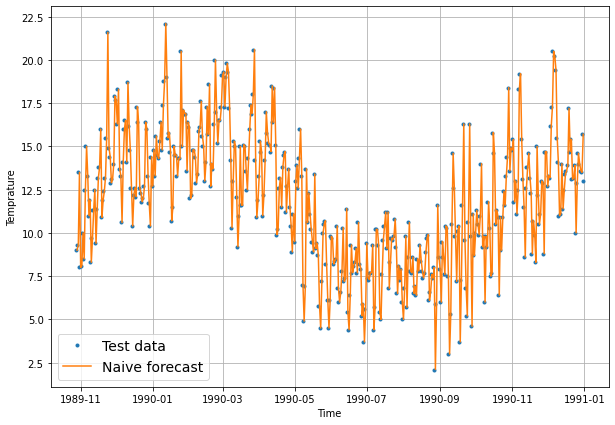

In [119]:

plt.figure(figsize=(10, 7))
offset = 300 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

In [122]:

naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 1.955144,
 'mse': 6.163279,
 'rmse': 2.4825952,
 'mape': 21.260248,
 'mase': 1.000805}

Now, we will begin preparing the temperature dataset for use with a deep learning model. This may involve making window, cleaning and preprocessing the data, as well as splitting it into training and testing sets. It is important to ensure that the data is in a suitable format for use with a deep learning model, as this can significantly impact model performance.

In [143]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7

In [144]:
full_windows, full_labels = make_windows(Temp, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3643, 3643)

In [145]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [20.7 17.9 18.8 14.6 15.8 15.8 15.8] -> Label: [17.4]
Window: [17.9 18.8 14.6 15.8 15.8 15.8 17.4] -> Label: [21.8]
Window: [18.8 14.6 15.8 15.8 15.8 17.4 21.8] -> Label: [20.]


In [146]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2914, 729, 2914, 729)

# Model_1: Dense Model

In [150]:
#Set the random seed to ensure reproducible results.
tf.random.set_seed(42)

# Create the model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear")                        
], name="model_1_dense")

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) 

# Fit model
model_1.fit(x=train_windows, 
            y=train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Let's find the best resulat for the model on the test dataset.

In [153]:
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

23/23 [==============================] - 0s 3ms/step - loss: 1.7532 - mae: 1.7532


[1.7532423734664917, 1.7532423734664917]

In [154]:
# Use model_1 to make predictions on the test dataset and examine the results.
model_1_preds = make_preds(model_1, test_windows)

23/23 [==============================] - 0s 1ms/step


In [155]:
#let's see the metrics
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 1.7532425,
 'mse': 4.991318,
 'rmse': 2.2341259,
 'mape': 20.539503,
 'mase': 0.8974551}

In [156]:
# compare with the naive results
naive_results

{'mae': 1.955144,
 'mse': 6.163279,
 'rmse': 2.4825952,
 'mape': 21.260248,
 'mase': 1.000805}

### Conclusion
Based on the results obtained, it appears that model_1 is able to outperform the naive model on the given temperature dataset. This suggests that the additional complexity of model_1, compared to the naive model, is justified by improved forecasting accuracy. 

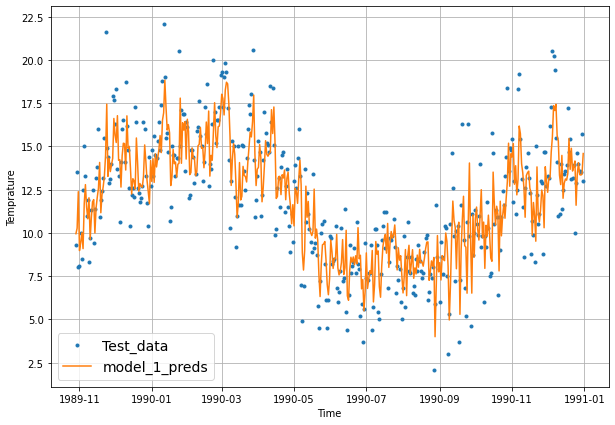

In [157]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

# Model_2 : Conv1D

In [158]:

tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_2_conv1D")

# Compile model
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_2.fit(train_windows,
            train_labels,
            batch_size=128, 
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])
     

In [159]:
# Load in best performing Conv1D model and evaluate it on the test data
model_2 = tf.keras.models.load_model("model_experiments/model_2_conv1D")
model_2.evaluate(test_windows, test_labels)

23/23 [==============================] - 0s 3ms/step - loss: 1.7534


1.7533625364303589

In [160]:
# Make predictions
model_2_preds = make_preds(model_2, test_windows)

23/23 [==============================] - 0s 3ms/step


In [161]:
# Evaluate metrics
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

{'mae': 1.7533627,
 'mse': 4.995236,
 'rmse': 2.2350025,
 'mape': 20.625725,
 'mase': 0.8975166}

# Conclusion
The results indicate that the Conv1D model is able to achieve performance that is comparable to that of the Dense model, and both models outperform the naive model on the temperature dataset. This suggests that both the Conv1D and Dense models are effective approaches for time series forecasting, and are able to outperform the simpler naive model. Further analysis and experimentation may be necessary to more fully understand the relative strengths and weaknesses of these models and to identify any potential areas for improvement.

# Model 3: LSTM

In [163]:

tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_3 = tf.keras.Model(inputs=inputs, outputs=output, name="model_3_lstm")

# Compile model
model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554 
model_3.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [164]:
model_3 = tf.keras.models.load_model("model_experiments/model_3_lstm/")
model_3.evaluate(test_windows, test_labels)

23/23 [==============================] - 0s 3ms/step - loss: 1.7522


1.7521922588348389

In [165]:
# Make predictions with LSTM model
model_3_preds = make_preds(model_3, test_windows)

23/23 [==============================] - 0s 2ms/step


In [166]:
# Evaluate metrics
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1.7521923,
 'mse': 5.0345683,
 'rmse': 2.2437844,
 'mape': 20.61181,
 'mase': 0.89691746}